In [38]:
import torch
import torch.utils.data
from torch import optim
from torchvision import datasets
from torchvision.transforms import transforms
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [18]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        """_summary_

        Args:
            in_features (_type_): 真实数据的维度，同时也是生成的假数据的维度，对于普通神经网络而言就是特征数量
        """
        super().__init__()
        self.disc = nn.Sequential(nn.Linear(in_features, 128)
                                  # ,nn.BatchNorm1d(128)  # 由于生成对抗网络的损失非常容易梯度消失，因此使用
                                  , nn.LeakyReLU(0.1), nn.Linear(128, 1), nn.Sigmoid()
                                  )

    def forward(self, data):
        """输入的data是真实数据时，Disc输出dx，输入的data是gz时，Disc输出dgz

        Args:
            data (_type_): _description_

        Returns:
            _type_: _description_
        """
        return self.disc(data)


class Generator(nn.Module):
    def __init__(self, in_features: int, out_features: int) -> None:
        """_summary_

        Args:
            in_features (int): 生成器的in_features，一般输入z的维度z_dim，该值可以定义
            out_features (int): 生成器的out_features，需要和真实数据的维度一致
        """
        super().__init__()
        self.gen = nn.Sequential(nn.Linear(in_features, 256)
                                 # ,nn.BatchNorm1d(256)
                                 , nn.LeakyReLU(0.1)
                                 , nn.Linear(256, out_features)
                                 , nn.Tanh()  # 用于归一化数据
                                 )

    def forward(self, z):
        gz = self.gen(z)
        return gz


In [19]:
# 检测生成器、判别器能否顺利跑通
data = torch.ones((10,64))
gen = Generator(64,784)
gen(data).shape  # 生成数据

torch.Size([10, 784])

In [20]:
disc = Discriminator(784)
disc(gen(data)).shape  # 输出唯一值概率

torch.Size([10, 1])

In [44]:
BATCH_SIZE = 32
LR = 3e-4
NUM_EPOCHS = 200
REALDATA_DIM = 28*28*1  # 784
Z_DIM = 64

# 设备设置
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 真实数据 - 以最简单的MNIST数据为例
transform = transforms.Compose([transforms.ToTensor()
                                # ,transforms.Normalize((0.1307), (0.3081))
                                , transforms.Normalize((0.5), (0.5))
                                ])
dataset = torchvision.datasets.MNIST(
    root=r"../datasets/", transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [28]:
# 设置一组固定的噪音数据，用于在训练中不断验证生成器的结果
# 作为需要输入生成器的噪音，这组数据的样本量应与BATCH_SIZE一致，维度可自由选择
# 注意区别于训练中不断放入G的噪音z
fixed_noise = torch.randn((BATCH_SIZE, Z_DIM)).to(DEVICE)

In [29]:
# 实例化判别器和生成器
gen = Generator(in_features=Z_DIM, out_features=REALDATA_DIM).to(DEVICE)
disc = Discriminator(in_features=REALDATA_DIM).to(DEVICE)

In [30]:
# 定义判别器与生成器所使用的优化算法
optim_disc = optim.Adam(disc.parameters(), lr=LR, betas=(0.9, 0.999))
optim_gen = optim.Adam(gen.parameters(), lr=LR, betas=(0.9, 0.999))

In [31]:
# 定义损失函数
criertion = nn.BCELoss(reduction="mean")  # 默认生成均值，也可以特定标明生成均值

In [32]:
len(dataloader)

1875

In [33]:
# 检查normalize之后图像的范围
for x, _ in dataloader:
    print(x.min(), x.max())
    break

tensor(-1.) tensor(1.)


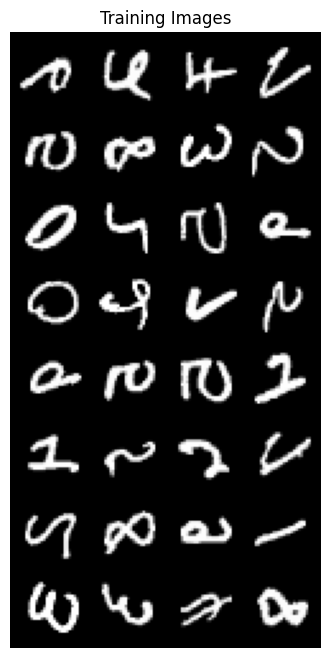

In [40]:
# 对当前数据集绘图
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=2, normalize=True)));

In [41]:
img_list = []  # 训练过程中根据fixed_noise生成的假数据
G_losses = []
D_real_losses = []
D_fake_losses = []
D_losses = []
iters = 0

In [45]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.view(-1, 784).to(DEVICE)
        batch_size = x.shape[0]

        ###########################################################
        # (1) 判别器的反向传播：最小化 -[logD(X) + log(1-D(G(z)))]
        ###########################################################

        # -logdx
        dx = disc(x).view(-1)
        loss_real = criertion(dx, torch.ones_like(dx))
        loss_real.backward()
        D_x = dx.mean().item()

        # -log(1-dgz)
        noise = torch.randn((batch_size, Z_DIM)).to(DEVICE)
        gz = gen(noise)
        dgz1 = disc(gz.detach())
        loss_fake = criertion(dgz1, torch.zeros_like(dgz1))
        loss_fake.backward()
        D_G_z1 = dgz1.mean().item()

        # 计算error
        errorD = (loss_real + loss_fake) / 2
        optim_disc.step()
        disc.zero_grad()

        ###########################################################
        # (2) 生成器的反向传播：最小化 -log(D(G(z)))
        ###########################################################
        # 生成需要输入criertion的真实标签1与预测概率gdz
        # 注意，由于此时判别器上的权重已经被更新过了，所以dgz的值会变化，需要重新生成
        dgz2 = disc(gz)
        # 计算errorG
        errorG = criertion(dgz2, torch.ones_like(dgz2))
        errorG.backward()  # 反向传播
        optim_gen.step()  # 更新生成器上的权重
        gen.zero_grad()  # 清零生成器更新后的梯度
        D_G_z2 = dgz2.mean().item()

        # 监控训练进度
        if batch_idx % 500 == 0 or batch_idx == 0:
            print('[%d|%d][%d|%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch+1, NUM_EPOCHS, batch_idx, len(dataloader), errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))

        # 保存errorG和errorD，以便后续绘图
        G_losses.append(errorG.item())
        D_real_losses.append(loss_real.item())
        D_fake_losses.append(loss_fake.item())
        D_losses.append(errorD.item())

        # 将固定噪音fixed_noise输入生成器，查看输出的结果变化
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS - 1) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).cpu().detach()
            print("fake data saved")
            img_list.append(fake.view(-1, 1, 28, 28))

        iters += 1

[1|200][0|1875]	Loss_D: 0.5711	Loss_G: 0.5691	D(x): 0.7464	D(G(z)): 0.5575 / 0.5745
fake data saved
[1|200][500|1875]	Loss_D: 0.6233	Loss_G: 0.4899	D(x): 0.7137	D(G(z)): 0.5824 / 0.6171
fake data saved
[1|200][1000|1875]	Loss_D: 0.7172	Loss_G: 0.4527	D(x): 0.7149	D(G(z)): 0.6473 / 0.6411
fake data saved
[1|200][1500|1875]	Loss_D: 0.6834	Loss_G: 0.4431	D(x): 0.6834	D(G(z)): 0.6041 / 0.6496
[2|200][0|1875]	Loss_D: 0.8254	Loss_G: 0.3803	D(x): 0.6402	D(G(z)): 0.6702 / 0.6897
fake data saved
[2|200][500|1875]	Loss_D: 0.7579	Loss_G: 0.4149	D(x): 0.8483	D(G(z)): 0.7219 / 0.6692
fake data saved
[2|200][1000|1875]	Loss_D: 0.6887	Loss_G: 0.4517	D(x): 0.7293	D(G(z)): 0.6406 / 0.6408
fake data saved
[2|200][1500|1875]	Loss_D: 0.7331	Loss_G: 0.4062	D(x): 0.7909	D(G(z)): 0.6970 / 0.6705
fake data saved
[3|200][0|1875]	Loss_D: 0.7342	Loss_G: 0.4867	D(x): 0.7140	D(G(z)): 0.6583 / 0.6220
fake data saved
[3|200][500|1875]	Loss_D: 0.6293	Loss_G: 0.5389	D(x): 0.7575	D(G(z)): 0.6055 / 0.5903
fake data save

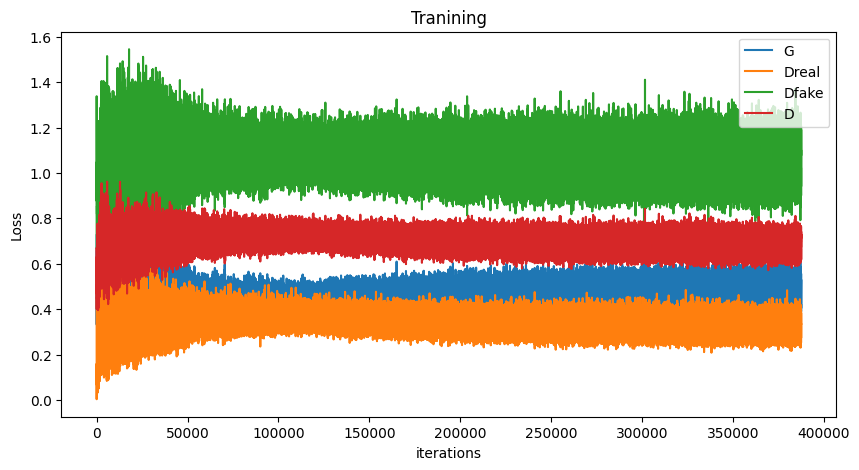

In [47]:
plt.figure(figsize=(10,5), dpi=100)
plt.title("Tranining")
plt.plot(G_losses, label="G")
plt.plot(D_real_losses, label="Dreal")
plt.plot(D_fake_losses, label="Dfake")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

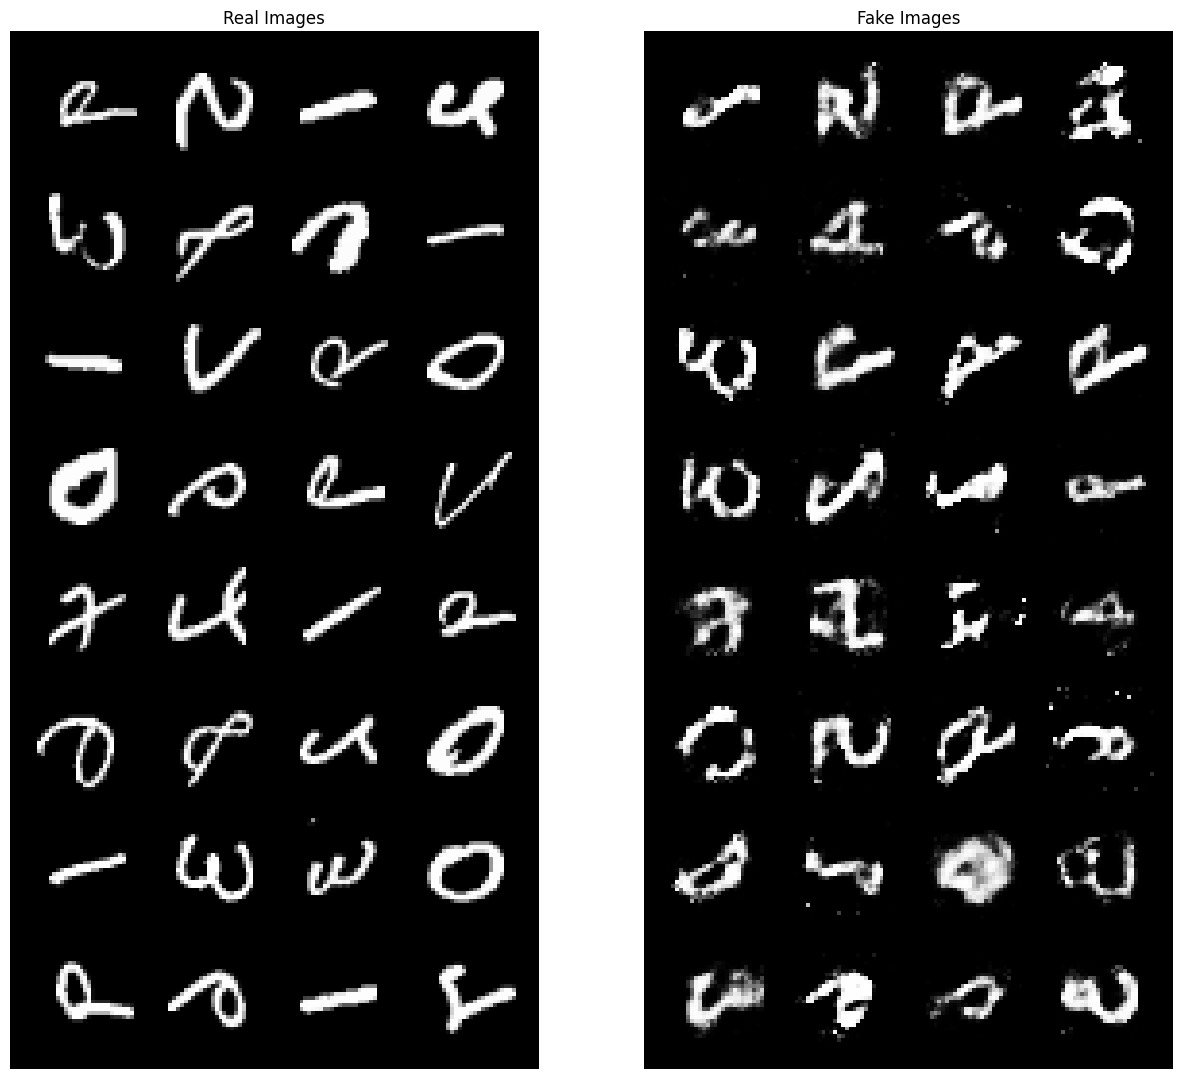

In [51]:
# 绘制原始图像与生成图像
real_batch = next(iter(dataloader))
# 原始图像中抽取一个batch
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:BATCH_SIZE], padding=5, normalize=True)))

# 绘制保存的最后一组生成数据
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1].reshape(-1, 1, 28, 28)[:BATCH_SIZE], padding=5, normalize=True)))
plt.show()